In [1]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size
    
model_file_name = "ms2deepscore_model.pt"
neg_test_spectra_file_name = "neg_testing_spectra.mgf"
pos_test_spectra_file_name = "pos_testing_spectra.mgf"

download_file("https://zenodo.org/records/14290920/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/14290920/files/ms2deepscore_model.pt?download=1", model_file_name)
download_file("https://zenodo.org/records/13934470/files/negative_testing_spectra.mgf?download=1", neg_test_spectra_file_name)
download_file("https://zenodo.org/records/13934470/files/positive_testing_spectra.mgf?download=1", pos_test_spectra_file_name)

The file ms2deepscore_settings.json already exists, the file won't be downloaded
The file ms2deepscore_model.pt already exists, the file won't be downloaded
The file neg_testing_spectra.mgf already exists, the file won't be downloaded
The file pos_testing_spectra.mgf already exists, the file won't be downloaded


In [2]:
from matchms.importing import load_from_mgf
from tqdm import tqdm
import os 


pos_val = list(tqdm(load_from_mgf(pos_test_spectra_file_name)))
neg_val = list(tqdm(load_from_mgf(neg_test_spectra_file_name)))

24911it [00:14, 1725.41it/s]
7142it [00:04, 1479.72it/s]


In [3]:
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
scores_between_ionmodes = CalculateScoresBetweenAllIonmodes(model_file_name, pos_val, neg_val)

/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


24911it [01:01, 405.81it/s]
7142it [00:08, 803.44it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 382.86it/s]


Calculating tanimoto scores
Calculating embeddings


24911it [00:30, 822.64it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:04<00:00, 397.24it/s]


Calculating tanimoto scores
Calculating embeddings


7142it [00:08, 801.29it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 380.95it/s]

Calculating tanimoto scores


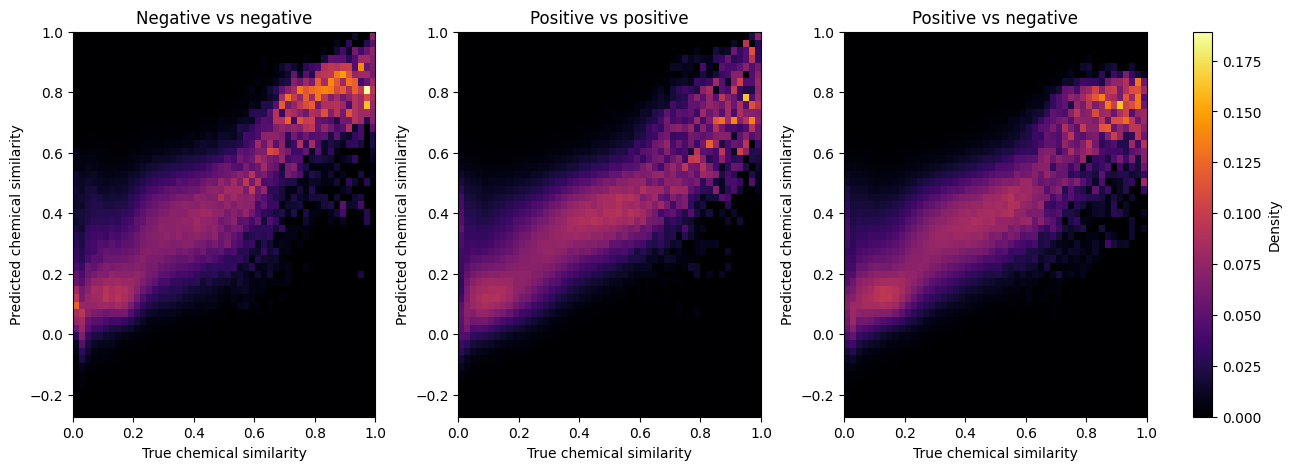

In [8]:
from ms2deepscore.benchmarking.plot_heatmaps import create_3_heatmaps
fig = create_3_heatmaps(scores_between_ionmodes, 50)
fig.savefig("./figures_benchmarking/heatmap.svg")

In [71]:
from scipy.stats import pearsonr
def get_pearson_correlation(scores):
    predictions = scores.get_average_prediction_per_inchikey_pair().to_numpy().flatten()
    tanimoto_scores = scores.tanimoto_df.to_numpy().flatten()
    # the cases where there is only one spectrum against itself result in nan. these values need to be removed
    nan_value_indexes = np.where(np.isnan(predictions))
    predictions_without_nan = np.delete(predictions, nan_value_indexes)
    tanimoto_without_nan = np.delete(tanimoto_scores, nan_value_indexes)
    print(pearsonr(predictions_without_nan, tanimoto_without_nan))

In [72]:
get_pearson_correlation(scores_between_ionmodes.pos_vs_neg_scores)
get_pearson_correlation(scores_between_ionmodes.pos_vs_pos_scores)
get_pearson_correlation(scores_between_ionmodes.neg_vs_neg_scores)


PearsonRResult(statistic=0.45574912770882686, pvalue=0.0)
PearsonRResult(statistic=0.4458051422152522, pvalue=0.0)
PearsonRResult(statistic=0.4790443688716387, pvalue=0.0)


Selecting available inchikey pairs per bin: 50it [00:00, 97.01it/s]
Selecting available inchikey pairs per bin: 50it [00:00, 197.69it/s]
Selecting available inchikey pairs per bin: 50it [00:00, 416.72it/s]


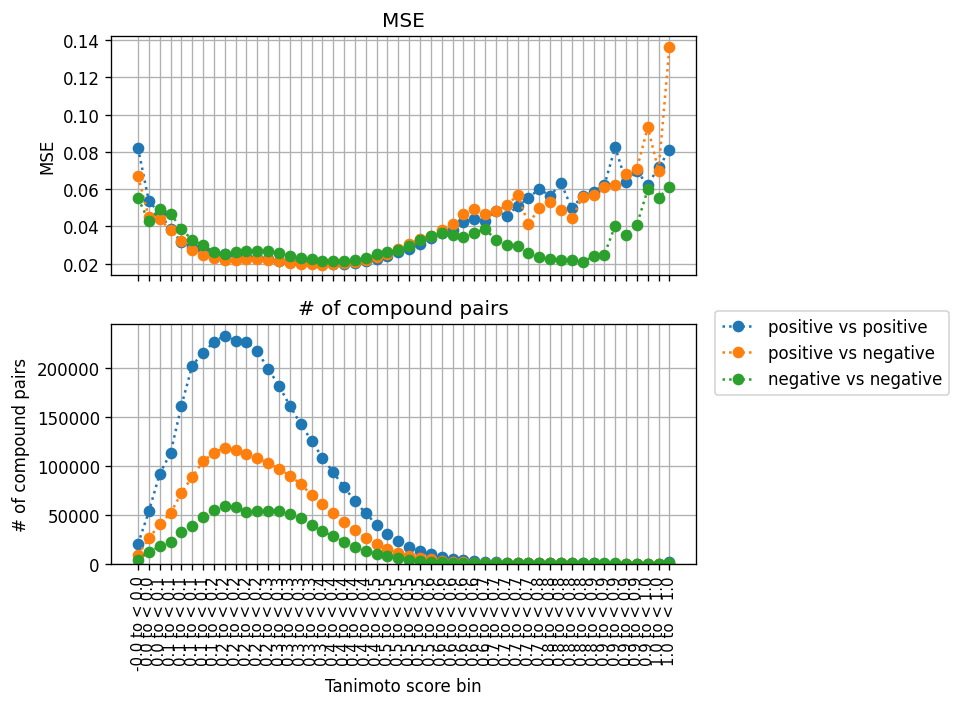

In [5]:
from ms2deepscore.benchmarking.plot_loss_per_bin import plot_loss_per_bin_multiple_benchmarks
plot_loss_per_bin_multiple_benchmarks(scores_between_ionmodes.list_of_predictions_and_tanimoto_scores(), 50)

Selecting available inchikey pairs per bin: 10it [00:00, 55.57it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 114.96it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 225.47it/s]


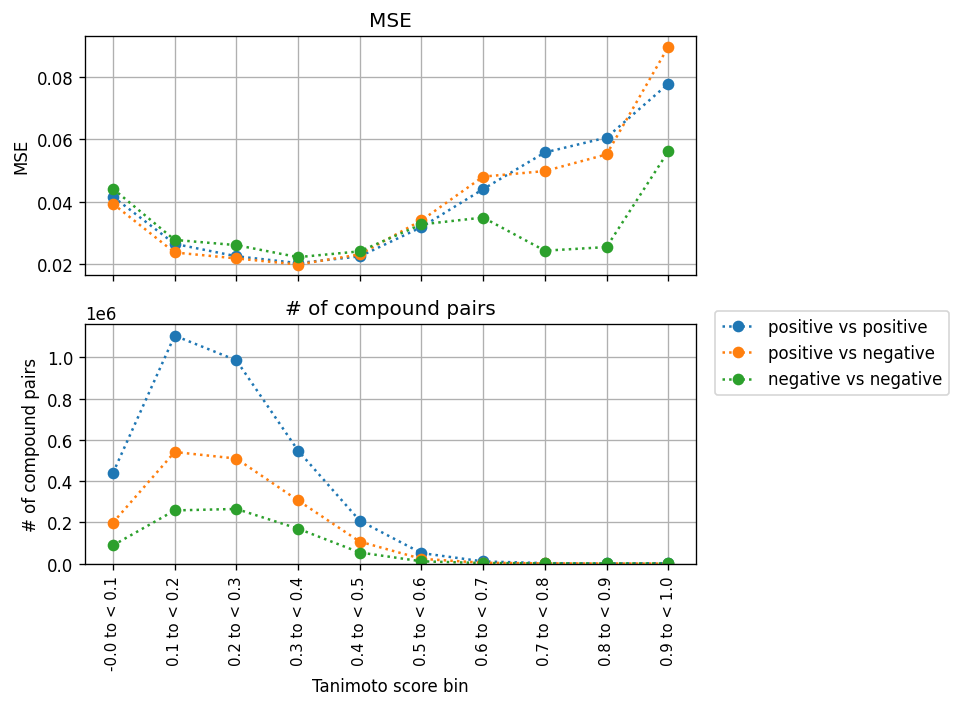

In [6]:
from ms2deepscore.benchmarking.plot_loss_per_bin import plot_loss_per_bin_multiple_benchmarks
plot_loss_per_bin_multiple_benchmarks(scores_between_ionmodes.list_of_predictions_and_tanimoto_scores(), 10, "MSE")

Selecting available inchikey pairs per bin: 50it [00:00, 95.97it/s]
Selecting available inchikey pairs per bin: 50it [00:00, 205.50it/s]
Selecting available inchikey pairs per bin: 50it [00:00, 415.41it/s]


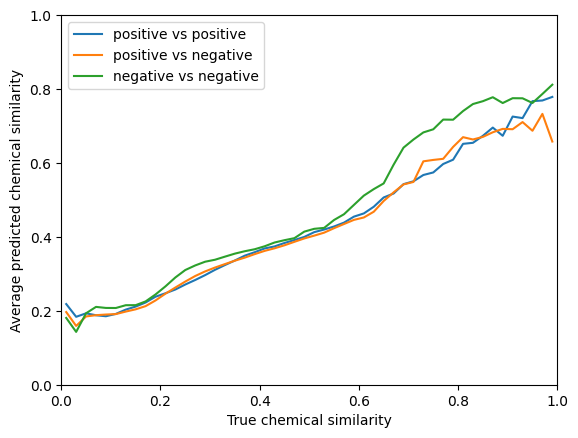

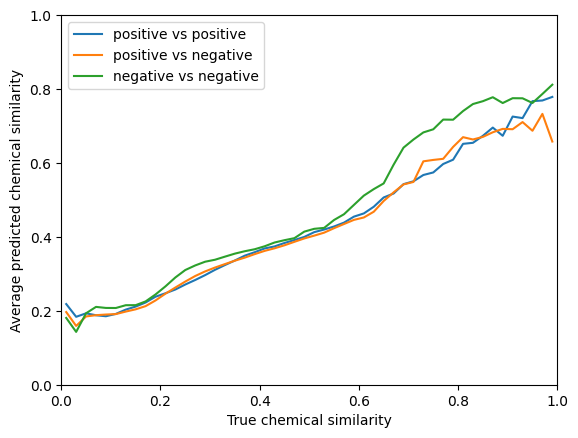

In [7]:
from ms2deepscore.benchmarking.plot_average_per_bin import plot_average_per_bin
plot_average_per_bin(scores_between_ionmodes, 50)